## Willingness to pay for Repairability for Mobile phones

### Set up

In [268]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

#### This notebook aims to provide data for insight into the Willingness to Pay for repairability of smartphones in the UK market. Data is collected through and online survey "WTP Repairability", then cleaned and analysed. OLS Regression models are estimated using the data. 

### Import survey data

In [269]:
data = pd.read_csv('data/survey_data_final.csv')
data = data.iloc[2:, :]

### Data Cleaning and Exploration

In [270]:
# Function to save value counts from data before cleaning
def save_count_data(data, category, col_name, count_data):
    temp_df = data[category].value_counts().rename_axis('subcategory').reset_index(name='counts')
    temp_df['category'] = col_name
    count_data = pd.concat([count_data, temp_df], ignore_index=True)
    return count_data

In [271]:
# Counts for invalid data before dropping
count_data = data.Finished.value_counts().rename_axis('subcategory').reset_index(name='counts')
count_data['category'] = "Finished survey"

count_data = save_count_data(data, 'Phone ownership', 'Phone ownership', count_data)

In [272]:
## Drop invalid rows (not finished surveys, no data consents and contract still paying, missing value)
print("Before dropping:", data.shape)
data = data.drop(data[data.Consent != "Yes"].index)
data = data.drop(data[data.Finished != "True"].index)
data = data.drop(data[data["Phone ownership"] == "Bought on contract - still paying"].index)
data = data.drop(data[data['phone cost_1'].isnull()].index)
print("After dropping:", data.shape)

Before dropping: (429, 47)
After dropping: (310, 47)


In [273]:
## Select desired columns from responses and reformat column names
wanted_cols = ['Phone ownership',
               'Phone ownership_4_TEXT',
               'phone cost_1',
               'State of phone',
               'State of phone_5_TEXT',
               'Brand of phone',
               'Brand of phone_4_TEXT',
               'Attachments_1',
               'Attachments_2',
               'Attachments_3',
               'Attachments_4',
               'env - q_1',
               'env - why?',
               'env - why?_4_TEXT',
               'control - q_1',
               'control - why',
               'control - why_4_TEXT',
               'gov - q_1',
               'gov - why',
               'gov - why_4_TEXT',
               'Gender',
               'Gender_4_TEXT',
               'Age',
               'Ethnicity',
               'Education',
               'Education_8_TEXT',
               'Employment status',
               'Income',
               'Family size']
responses = data.filter(wanted_cols, axis=1)

# Renaming columns
responses = responses.rename(columns={'phone cost_1':'phone_cost',
                                      'Phone ownership_4_TEXT': 'phone_ownership_response', 
                                      'Gender_4_TEXT': 'gender_response',
                                      'Education_8_TEXT':'education_response', 
                                      'Brand of phone_4_TEXT': 'brand_phone_response',
                                      'State of phone':'state_phone',
                                      'Brand of phone': 'brand_phone',
                                      'State of phone_5_TEXT':'state_phone_response'})

responses = responses.rename(columns=str.lower)
responses.columns = responses.columns.str.replace(" ", "_")
            
print("Rows:", responses.shape[0], " Columns:", responses.shape[1])

Rows: 310  Columns: 29


In [274]:
## Create new column Treatment (env, gov, cont) to categorise different treatments, put all WTP into one column and all whys into one column
responses['treatment'] = ''
responses['treatment'] = np.where(responses['env_-_q_1'].notnull(), 'env', responses['treatment'])
responses['treatment'] = np.where(responses['gov_-_q_1'].notnull(), 'gov', responses['treatment'])
responses['treatment'] = np.where(responses['control_-_q_1'].notnull(), 'cont', responses['treatment'])

# Combining all WTP to one column
q_cols = ['env_-_q_1', 'gov_-_q_1', 'control_-_q_1']
responses[q_cols] = responses[q_cols].apply(pd.to_numeric)
responses['WTP'] = responses[q_cols].sum(axis=1)
responses = responses.drop(q_cols, axis=1)

describe_WTP = responses['WTP'].describe()

# Combining survey written responses
why_cols = ['env_-_why?', 'env_-_why?_4_text', 'control_-_why', 'control_-_why_4_text', 'gov_-_why', 'gov_-_why_4_text']
responses['WTP_response'] = responses[why_cols].fillna('').sum(axis=1)
responses = responses.drop(why_cols, axis=1)

print("Rows:", responses.shape[0], " Columns:", responses.shape[1])

Rows: 310  Columns: 23


In [275]:
## Willingness to pay as percentage of phone cost
describe_p_cost = responses['phone_cost'].describe()

responses['phone_cost'] = responses['phone_cost'].apply(pd.to_numeric)
responses['WTP_per'] = np.where(responses['phone_cost'] < 1, responses['phone_cost'], responses['WTP']/(responses['phone_cost']))
responses['WTP_per']= responses['WTP_per'].round(3)

describe_WTP_per = responses['WTP_per'].describe()

In [276]:
## Isolate protest zeros
protest_statements = ["It should be the producer's responsibility to pay",
                      "Other, please specifyrepairability is important to me but i can't afford a fair phone and the cameras are rubbish on them from seeing my friends",
                      "Other, please specifyPhones should be made repairable or more durable"]
responses['protest_flag'] = responses['WTP_response'].map(lambda res: True if (res in protest_statements) else False)

# Save data on counts - on protest
general_data = save_count_data(responses, 'protest_flag', 'Protest Flag', count_data)

responses = responses.drop(responses[responses['protest_flag']== True].index) 

print("Rows:", responses.shape[0], " Columns:", responses.shape[1])

Rows: 305  Columns: 25


In [277]:
# Counts for treatment, demographic variables and phone baseline information
categories = ["treatment", "gender", "ethnicity", "age", "education", "employment_status", "family_size", "income", "phone_ownership", "state_phone", "brand_phone"]
for cat in categories:
    general_data = save_count_data(responses, cat, cat, count_data)

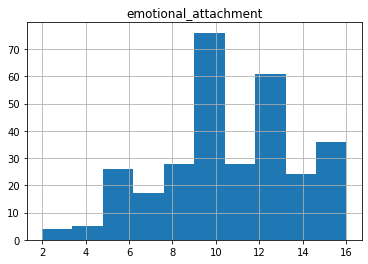

In [278]:
## Emotional Attachment - likert to numbers and sum 
likert_to_num = {"Strongly Disagree":0, "Somewhat Disagree":1, "Neither Agree nor Disagree": 2, "Somewhat Agree":3, "Strongly Agree":4}
attachment_cols = ['attachments_1', 'attachments_2', 'attachments_3', 'attachments_4']
for col in attachment_cols:
    responses[col] = responses[col].map(lambda x: likert_to_num[x])
    
responses['emotional_attachment'] = responses[attachment_cols].sum(axis=1)
responses.hist(column='emotional_attachment')

# drop original attachment cols
responses = responses.drop(attachment_cols, axis=1)

# Saving emotional attachment data description (TODO: saving describe data?)
describe_emo = responses['emotional_attachment'].describe()

In [279]:
## Ethnicity categorisation
responses['ethnicity'] = responses['ethnicity'].map(lambda x: "White" if ("White" in x and "Mixed" not in x ) else ("Prefer not to say" if x == "Prefer not to say" else "BAME"))
count_data = save_count_data(responses, 'ethnicity', 'Ethnicity - categorised', count_data)

In [280]:
## Age categorisation
responses['age'] = responses['age'].map(lambda x: "Over 65" if (x == "65 - 74" or x == "75 - 84" or x == "85 or older"  ) else x)
count_data = save_count_data(responses, 'age', 'Age - categorised', count_data)

In [281]:
## Gender categorisation
responses['gender'] = responses['gender'].map(lambda x: "Prefer not to say" if x == "Prefer to self-describe" else x)
count_data = save_count_data(responses, 'gender', 'Gender - categorised', count_data)

In [282]:
## Combining describe data
describe_data = pd.DataFrame({'WTP': describe_WTP,'Phone cost': describe_p_cost,
                              'WTP per': describe_WTP_per, 'Emotional Attachment': describe_emo })

In [283]:
## Export to CSV
responses.to_csv('data/cleaned.csv', index=False)

export_cols = ['category', 'subcategory', 'counts'] 
count_data = count_data[export_cols]
count_data.to_csv('results/counts_data.csv', index=False)

describe_data.to_csv('results/describe_data.csv', index=True)

### Model Preparation

In [284]:
## Choose variables wanted for modelling
model_vars = ['WTP_per', 'WTP', 'phone_cost', 'protest_flag', 'treatment', 'emotional_attachment', 'gender', 'age', 'ethnicity', 'education', 'employment_status', 'income',
             'family_size']
df = responses[model_vars].copy()
print("Rows:", df.shape[0], " Columns:", df.shape[1])

Rows: 305  Columns: 13


In [285]:
# Categorise emotional attachment at thresholds from 8 to 13
for threshold in range(8, 14):
    col_name = 'emotional_attachment_' + str(threshold)
    responses[col_name] = np.where(responses['emotional_attachment'] > threshold, 1, 0)
    count_data = save_count_data(responses, col_name, 'Emotional Attachment '+str(threshold), count_data)

In [286]:
## age binary categorisation - baseline: younger than 45
older = ["Over 65", "55 - 64", "45 - 54"]
df['age_bin'] = df['age'].map(lambda x: 1 if (x in older ) else 0)
df['age_bin'].value_counts()

0    241
1     64
Name: age_bin, dtype: int64

In [287]:
## income binary categorisation - baseline below 40,000
higher_income = ["£40,000 to £49,999", "£50,000 to £59,999", "£60,000 to £69,999",
                 "£70,000 to £79,999", "£80,000 to £89,999", "£90,000 to £99,999", "£100,000 to £149,999"]
df['income_bin'] = df['income'].map(lambda x: 1 if (x in higher_income ) else 0)
df['income_bin'].value_counts()

0    224
1     81
Name: income_bin, dtype: int64

In [288]:
## family size binary categorisation - baseline no dependents
df['family_size_bin'] = df['family_size'].map(lambda x: 0 if (x == "None" ) else 1)
df['family_size_bin'].value_counts()

0    217
1     88
Name: family_size_bin, dtype: int64

In [289]:
## education binary categorisation - baseline below Master's degree
higher_edu = ["Master's degree", "Doctoral degree"]
df['education_bin'] = df['education'].map(lambda x: 1 if (x in higher_edu ) else 0)
df['education_bin'].value_counts()

0    155
1    150
Name: education_bin, dtype: int64

In [290]:
## employment status categorisation - baseline employed
employed = ["In full-time employment", "In part-time employment", "Self employed"]
df['employment_bin'] = df['employment_status'].map(lambda x: 0 if (x in employed) else 1)
df['employment_bin'].value_counts()

0    187
1    118
Name: employment_bin, dtype: int64

In [291]:
## Categorical expansion - one hot encoding
categorical_cols = ['treatment', 'emotional_attachment', 'gender', 'age', 'ethnicity',
                    'education', 'employment_status', 'income', 'family_size']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_res = pd.DataFrame(OH_encoder.fit_transform(df[categorical_cols]))
OH_res.columns = OH_encoder.get_feature_names_out(categorical_cols)
OH_res.index = df.index

model_data = pd.concat([df, OH_res], axis=1)
model_data = model_data.drop(categorical_cols, axis=1)

### Modeling

In [292]:
baseline_vars = ['treatment_cont', 'emotional_attachment_low', 'gender_Female', 'age_18 - 24',
                 'ethnicity_White', "education_Master's degree", "employment_status_In full-time employment",
                "income_Less than £10,000", 'family_size_None']

drop_vars = ['gender_Non-binary / third gender', 'gender_Prefer not to say', 'income_Not sure', 
             'income_Prefer not to say', 'education_Prefer not to say', 'education_Other, please specify', 
             'ethnicity_Prefer not to say']

In [293]:
treatment_vars= []
emo_vars = []
eth_vars = []
gender_vars = []
age_vars = []
age_bin_vars = []
edu_vars = []
edu_bin_vars = []
emp_vars = []
emp_bin_vars = []
income_vars = []
income_bin_vars = []
fam_vars = []
fam_bin_vars = []

for col in model_data.columns:
    if col not in baseline_vars and col not in drop_vars:
        if 'treatment' in col:
            treatment_vars.append(col)
        elif 'emotional' in col:
            emo_vars.append(col)
        elif 'ethnicity' in col:
            eth_vars.append(col)
        elif 'gender' in col:
            gender_vars.append(col)
        elif 'age' in col:
            if 'age_bin' in col:
                age_bin_vars.append(col)
            else:
                age_vars.append(col)
        elif 'employment' in col:
            if 'employment_bin' in col:
                emp_bin_vars.append(col)
            else:
                emp_vars.append(col)
        elif'education' in col:
            if 'education_bin' in col:
                edu_bin_vars.append(col)
            elif 'education_' in col:
                edu_vars.append(col)
        elif 'income' in col:
            if 'income_bin' in col:
                income_bin_vars.append(col)
            else:
                income_vars.append(col)
        elif 'family' in col:
            if 'family_size_bin' in col:
                fam_bin_vars.append(col)
            else:
                fam_vars.append(col)

In [294]:
## Relationship columns
relationship_vars = []
bin_vars = eth_vars + gender_vars + age_bin_vars + edu_bin_vars + emp_bin_vars + income_bin_vars + fam_bin_vars + emo_vars
for treat in treatment_vars:
    for bi in bin_vars:
        col_name = treat+' x '+ bi
        relationship_vars.append(col_name)
        print(col_name)
        model_data[col_name] = model_data[treat].multiply(model_data[bi])

treatment_env x ethnicity_BAME
treatment_env x gender_Male
treatment_env x age_bin
treatment_env x education_bin
treatment_env x employment_bin
treatment_env x income_bin
treatment_env x family_size_bin
treatment_env x emotional_attachment_2
treatment_env x emotional_attachment_3
treatment_env x emotional_attachment_4
treatment_env x emotional_attachment_5
treatment_env x emotional_attachment_6
treatment_env x emotional_attachment_7
treatment_env x emotional_attachment_8
treatment_env x emotional_attachment_9
treatment_env x emotional_attachment_10
treatment_env x emotional_attachment_11
treatment_env x emotional_attachment_12
treatment_env x emotional_attachment_13
treatment_env x emotional_attachment_14
treatment_env x emotional_attachment_15
treatment_env x emotional_attachment_16
treatment_gov x ethnicity_BAME
treatment_gov x gender_Male
treatment_gov x age_bin
treatment_gov x education_bin
treatment_gov x employment_bin
treatment_gov x income_bin
treatment_gov x family_size_bin
tr

In [295]:
model_data = model_data.drop(model_data[model_data['protest_flag']== True].index)

model_data_cont = model_data.copy().drop(model_data[model_data['treatment_cont']== 0].index) 
model_data_env = model_data.copy().drop(model_data[model_data['treatment_env']== 0].index)
model_data_gov = model_data.copy().drop(model_data[model_data['treatment_gov']== 0].index)

In [296]:
print(model_data.columns[50:60])

Index(['employment_status_In full-time employment',
       'employment_status_In part-time employment',
       'employment_status_Not in employment',
       'employment_status_Self employed', 'income_Less than £10,000',
       'income_Not sure', 'income_Prefer not to say',
       'income_£10,000 to £19,999', 'income_£100,000 to £149,999',
       'income_£150,000 or more'],
      dtype='object')


In [297]:
## Export to CSV
model_data.to_csv('data/model.csv', index=False)

## Final Modelling

In [298]:
def saving_experiments(exp_list, file_name):
    for ex in exp_list:
        temp = pd.DataFrame(ex.summary().tables[1])
        temp.to_csv('results/'+file_name, mode='a', index=False, header=False)
    return

In [299]:
def mean_confidence_interval(data=[], confidence=0.95):
    mean = []
    ci = []
    for s in data:
        a = 1.0 * np.array(s)
        n = len(a)
        m, se = np.mean(a), st.sem(a)
        h = se * st.t.ppf((1 + confidence) / 2., n-1)
        mean.append(m)
        ci.append(h)
        
    return mean, ci

### Results 1: WTP and WTP% data 

<AxesSubplot:ylabel='Frequency'>

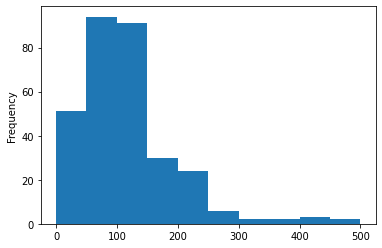

In [300]:
model_data['WTP'].plot(kind='hist')

In [331]:
data_wtp = [model_data['WTP'], model_data_cont['WTP'], model_data_env['WTP'], model_data_gov['WTP']]
mean_WTP, ci_WTP = mean_confidence_interval(data_wtp)

In [332]:
data_wtp_per = [model_data['WTP_per'], model_data_cont['WTP_per'], model_data_env['WTP_per'], model_data_gov['WTP_per']]
mean_WTP_per, ci_WTP_per = mean_confidence_interval(data_wtp_per)

In [333]:
res1_data = pd.DataFrame({'Mean WTP': mean_WTP,'Confidence Interval WTP': ci_WTP,
                              'Mean WTP per': mean_WTP_per, 'Confidence Interval WTP oer': ci_WTP_per })
res1_data.to_csv('results/res_1.csv', index=False)

### Experiment 2: Seperate regression with core variables and socioeconomic variables

In [304]:
# Model 6: All - X (income + education + employment + fam)
mod6_vars = treatment_vars + income_vars + edu_vars + emp_vars + fam_vars
mod6_X = model_data[mod6_vars]
mod6_y = model_data['WTP_per']

mod6 = sm.OLS(mod6_y, mod6_X)
res6 = mod6.fit()

In [305]:
exp_2 = [res6]
saving_experiments(exp_2, 'res_2.csv')

### Experiment 3: Emotional attachment regression with both treatments

In [306]:
# Model 7: All - X (treatments + emotional)
mod7_vars = treatment_vars + emo_vars + ['phone_cost']
mod7_X = model_data[mod7_vars]
mod7_y = model_data['WTP']

mod7 = sm.OLS(mod7_y, mod7_X)
res7 = mod7.fit()

In [307]:
exp_3 = [res7]
saving_experiments(exp_3, 'res_3.csv')

### Experiment 4: Relationship between env treatment and each demographic variable

In [308]:
# Model 8: All - X (treatments + gender + treatment x gender)
mod8_vars = treatment_vars  + bin_vars + ['treatment_env x gender_Male', 'treatment_gov x gender_Male', 'phone_cost']
mod8_X = model_data[mod8_vars]
mod8_y = model_data['WTP']

mod8 = sm.OLS(mod8_y, mod8_X)
res8 = mod8.fit()

In [309]:
# Model 9: All - X (treatments + ethnicity + treatment x ethnicity)
mod9_vars = treatment_vars + bin_vars + ['treatment_env x ethnicity_BAME', 'treatment_gov x ethnicity_BAME', 'phone_cost']
mod9_X = model_data[mod9_vars]
mod9_y = model_data['WTP']

mod9 = sm.OLS(mod9_y, mod9_X)
res9 = mod9.fit()

In [310]:
# Model 10: All - X (treatments + age + treatment x age)
mod10_vars = treatment_vars + bin_vars + ['treatment_env x age_bin', 'treatment_gov x age_bin', 'phone_cost']
mod10_X = model_data[mod10_vars]
mod10_y = model_data['WTP']

mod10 = sm.OLS(mod10_y, mod10_X)
res10 = mod10.fit()

In [311]:
# Model 11 :All - X (treatments + income + treatment x income)
mod11_vars = treatment_vars + bin_vars + ['treatment_env x income_bin', 'treatment_gov x income_bin', 'phone_cost']
mod11_X = model_data[mod11_vars]
mod11_y = model_data['WTP']

mod11 = sm.OLS(mod11_y, mod11_X)
res11 = mod11.fit()

In [312]:
# Model 12 :All - X (treatments + employment + treatment x employment)
mod12_vars = treatment_vars + bin_vars + ['treatment_env x employment_bin', 'treatment_gov x employment_bin', 'phone_cost']
mod12_X = model_data[mod12_vars]
mod12_y = model_data['WTP']

mod12 = sm.OLS(mod12_y, mod12_X)
res12 = mod12.fit()

In [313]:
# Model 13 :All - X (treatments + family size + treatment x family size)
mod13_vars = treatment_vars + bin_vars + ['treatment_env x family_size_bin', 'treatment_gov x family_size_bin', 'phone_cost']
mod13_X = model_data[mod13_vars]
mod13_y = model_data['WTP']

mod13 = sm.OLS(mod13_y, mod13_X)
res13 = mod13.fit()

In [314]:
# Model 14 :All - X (treatments + edu + treatment x edu)
mod14_vars = treatment_vars + bin_vars + ['treatment_env x education_bin', 'treatment_gov x education_bin', 'phone_cost']
mod14_X = model_data[mod14_vars]
mod14_y = model_data['WTP']

mod14 = sm.OLS(mod14_y, mod14_X)
res14 = mod14.fit()

In [315]:
# Model 15 :All - X (treatments + emo + treatment x emo)
mod15_vars = treatment_vars + bin_vars + emo_vars + ['treatment_env x emotional_attachment_13', 'treatment_gov x emotional_attachment_13', 'phone_cost']
mod15_X = model_data[mod15_vars]
mod15_y = model_data['WTP']

mod15 = sm.OLS(mod15_y, mod15_X)
res15 = mod15.fit()

In [316]:
# Model 16 :All - X (treatments + emo + treatment x emo)
mod16_vars = treatment_vars + bin_vars +  relationship_vars + ['phone_cost']
mod16_X = model_data[mod16_vars]
mod16_y = model_data['WTP']

mod16 = sm.OLS(mod16_y, mod16_X)
res16 = mod16.fit()

In [317]:
#TODO (maybe no saving coefficients)
exp_4 = [res8, res9, res10, res11, res12, res13, res14, res15]
saving_experiments(exp_4, 'res_4.csv')

In [318]:
t_test = sm.stats.ttest_ind(gov_coef, env_coef)
print("t val:", t_test[0], "p val:", t_test[1], "degrees of freedom:", t_test[2])

NameError: name 'gov_coef' is not defined

### Experiment 5: Increasing socio economic variables until we have full model with all variables

In [319]:
# Model 22: All - X (treatment_vars, core)
mod22_vars = treatment_vars + age_vars + gender_vars + eth_vars + ['phone_cost']
mod22_X = model_data[mod22_vars]
mod22_y = model_data['WTP']

mod22 = sm.OLS(mod22_y, mod22_X)
res22 = mod22.fit()

In [320]:
# Model 23: All - X (treatment_vars, core + income)
mod23_vars = treatment_vars + age_vars + gender_vars + eth_vars + income_vars + ['phone_cost']
mod23_X = model_data[mod23_vars]
mod23_y = model_data['WTP']

mod23 = sm.OLS(mod23_y, mod23_X)
res23 = mod23.fit()

In [321]:
# Model 24: All - X (treatment_vars, core + income + education)
mod24_vars = treatment_vars + age_vars + gender_vars + eth_vars + income_vars + edu_vars + ['phone_cost']
mod24_X = model_data[mod24_vars]
mod24_y = model_data['WTP']

mod24 = sm.OLS(mod24_y, mod24_X)
res24 = mod24.fit()

In [322]:
# Model 25: All - X (treatment_vars, core + income + education + employment)
mod25_vars = treatment_vars + age_vars + gender_vars + eth_vars + income_vars + edu_vars + emp_vars + ['phone_cost']
mod25_X = model_data[mod25_vars]
mod25_y = model_data['WTP']

mod25 = sm.OLS(mod25_y, mod25_X)
res25 = mod25.fit()

In [323]:
# Model 26: All - X (treatment_vars, core + income + education + employment + fam [ALL])
mod26_vars = treatment_vars + bin_vars + ['phone_cost']
mod26_X = model_data[mod26_vars]
mod26_y = model_data['WTP']

mod26 = sm.OLS(mod26_y, mod26_X)
res26 = mod26.fit()

In [324]:
exp_5 = [res22, res23, res24, res25, res26]
saving_experiments(exp_5, 'res_5.csv')

### Experiment 6: Using interaction variables

In [325]:
# Model 27: All - X (treatment_vars, core + income + education + employment + fam [ALL])
mod27_vars = treatment_vars + eth_vars + gender_vars + age_vars + edu_vars + emp_vars + income_vars + fam_vars + emo_vars + ['phone_cost']
mod27_X = model_data[mod27_vars]
mod27_y = model_data['WTP']

mod27 = sm.OLS(mod27_y, mod27_X)
res27 = mod27.fit()

In [326]:
exp_6 = [res27]
saving_experiments(exp_6, 'res_6.csv')

### Experiment 7: T-test on survey data means against historical value

In [327]:
rvs1 = st.norm.rvs(loc=61, scale=21, size=len(model_data['WTP']))
st.ttest_ind(model_data['WTP'], rvs1)

Ttest_indResult(statistic=9.67815254305793, pvalue=1.0604605057241301e-20)

In [328]:
rvs2 = st.norm.rvs(loc=61, scale=21, size=len(model_data_cont['WTP']))
st.ttest_ind(model_data_cont['WTP'], rvs2)

Ttest_indResult(statistic=4.99251846148903, pvalue=1.2266561064984965e-06)

In [329]:
rvs3 = st.norm.rvs(loc=61, scale=21, size=len(model_data_env['WTP']))
st.ttest_ind(rvs3, model_data_env['WTP'])

Ttest_indResult(statistic=-5.105804193217802, pvalue=7.900303519363326e-07)

In [330]:
rvs4 = st.norm.rvs(loc=61, scale=21, size=len(model_data_gov['WTP']))
st.ttest_ind(rvs4, model_data_gov['WTP'])

Ttest_indResult(statistic=-6.889732882508218, pvalue=7.436392228064648e-11)